# Tutorial 1: DLPFC Data Analysis (10X Visium)


<p align="left">
  <img src="IMG_notebook/DLPFC.png" width="150">
</p>

> This tutorial guides you through the process of identifying spatial domains in Visium data from the human dorsolateral prefrontal cortex (DLPFC) using SemanticST.

<h3>1. Import necessary packages</h3>

In [1]:
from sklearn import metrics
import torch
import copy
import os
import random
import numpy as np
from semanticst.loading_batches import PrepareDataloader
from semanticst.loading_batches import Dataloader
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import torch.utils.data as data
from semanticst.main import Config

/home/roxana/anaconda3/envs/semanticst3/lib/python3.9/site-packages/torch/__config__.py:10: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._show_config()


<h3>2. Read data and import device!</h3>

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"You are using *{device}*")
BASE_PATH = Path('/media/rokny/DATA1/Roxana/Data/1.DLPFC/')
sample_name ='151673'
section_id = '151673'
spot_paths= Path(f'{BASE_PATH}/{sample_name}/')
if sample_name in ['151669', '151670', '151671', '151672']:
    n_clusters = 5
else:
    n_clusters = 7

You are using *cuda:0*


In [3]:
dataset="DLPFC"
adata = sc.read_visium(spot_paths)
adata.var_names_make_unique()
print(adata)

/home/roxana/anaconda3/envs/semanticst3/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/roxana/anaconda3/envs/semanticst3/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


<h3>3. Define the Spatial Transcriptomics (ST) Data Type and Run SemanticST </h3>
Available: ''Xenium', 'Visium', 'Stereo', Slide.
<br>
It is essential to specify the type of ST data, as different ST technologies require distinct preprocessing steps. Additionally, you have the option to select between mini-batch training for large datasets and full dataset training for smaller ones, ensuring efficient data processing and model performance.</h3>

In [5]:
dtype = "Visium"  # Change to "h5ad" if necessary
config=Config(device=device,dtype=dtype, use_mini_batch=False)
from semanticst.SemanticST_main import Semantic as Trainer
config_used = copy.copy(config)
model = Trainer(adata,config)  
adata=model.train()  # Train the model


🚀 Welcome to SemanticST! 🚀

📢 Recommendation: If your dataset contains more than 40000 spots or cells, we suggest using **mini-batch training** for efficiency.

✅ Using Full Dataset Training (No Mini-Batching). 🔥


/home/roxana/anaconda3/envs/semanticst3/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Begin to train ST data...


Learning Semantic graphs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:12<00:00, 19.68epoch/s]


Semantic Graph Learning Completed


Feature Learning Epochs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:25<00:00,  3.07it/s]


<h3>4. Plot Ground Truth </h3>

In [6]:

df_meta = pd.read_csv(f'{spot_paths}/metadata.tsv', sep='\t')
df_meta_layer = df_meta['layer_guess']
adata.obs['ground_truth'] = df_meta_layer.values
adata = adata[~pd.isnull(adata.obs['ground_truth'])]

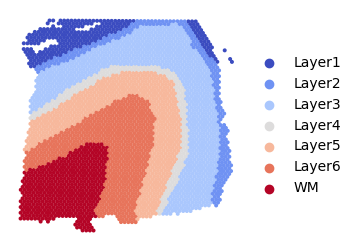

In [10]:
plt.rcParams["figure.figsize"] = (3,3)
sc.pl.embedding(adata, basis="spatial", color="ground_truth",palette='coolwarm', show=False, title='')
plt.gca().invert_yaxis()  # This will invert the y-axis
plt.axis('off')
plt.show()

<h3>5. Clustering </h3>
    - mclust 

In [8]:
# clustering

n_cluster=7
tool = 'mclust' # mclust, leiden, and louvain

# clustering
from semanticst.utils import clustering
clustering(adata,seed=2025, n_clusters=n_cluster, method=tool,key='emb_decoder')


/home/roxana/anaconda3/envs/semanticst3/lib/python3.9/site-packages/semanticst/utils.py:68: ImplicitModificationWarning: Setting element `.obsm['emb_pca']` of view, initializing view as actual.
  adata.obsm['emb_pca'] = embedding
Unable to determine R library path: Command '('/usr/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 1.
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


===== 151673 ARI score: 0.641
===== 151673 NMI score: 0.744
===== 151673 HMO score: 0.725


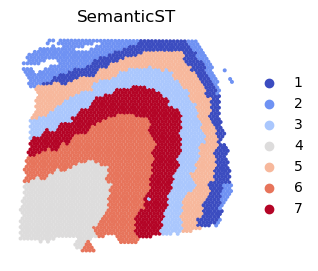

In [12]:
ARI = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['ground_truth'])
NMI = metrics.normalized_mutual_info_score(adata.obs['domain'], adata.obs['ground_truth'])
HMO= metrics.homogeneity_score(adata.obs['domain'], adata.obs['ground_truth'])
print('===== {} ARI score: {:.3f}'.format(sample_name, ARI))

print('===== {} NMI score: {:.3f}'.format(sample_name, NMI))

print('===== {} HMO score: {:.3f}'.format(sample_name, HMO))

plt.rcParams["figure.figsize"] = (3,3)
sc.pl.embedding(adata, basis="spatial", color="domain",palette='coolwarm', show=False, title="SemanticST")
plt.gca().invert_yaxis()  # This will invert the y-axis
plt.axis('off')
# plt.savefig(f"{dir_output}/pred.png", dpi=300,bbox_inches='tight')
plt.show()